In [18]:
# Step 1 — Imports & settings
from __future__ import annotations

import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pandas display tweaks (handy in notebooks)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Minimal logger for notebooks (INFO by default)
import logging
logger = logging.getLogger("tt_explore")
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h)
logger.setLevel(logging.INFO)

# Project paths
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
assert DATA_RAW.exists(), f"Raw data folder not found: {DATA_RAW}"
logger.info(f"Project root: {PROJECT_ROOT}")
logger.info(f"Raw data dir: {DATA_RAW}")

[INFO] Project root: c:\Users\Bálint\Documents\Pet_projects\tastetrend_analytics_genai
[INFO] Raw data dir: c:\Users\Bálint\Documents\Pet_projects\tastetrend_analytics_genai\data\raw


In [ ]:
# Step 2 — Unified schema & mappings
STANDARD_COLS = [
    "review_id", "customer_name", "review_date", "rating_raw", "rating_scale",
    "rating_1_5", "review_text", "location", "restaurant_name",
    "total_spent", "tip_amount", "tip_percentage", "party_size",
    "age_range", "gender", "ethnicity", "source_file"
]

SYNONYMS: Dict[str, List[str]] = {
    "review_id": ["review_id", "review_number", "id"],
    "customer_name": ["customer_name", "guest_name", "name"],
    "review_date": ["date", "visit_date", "review_date"],
    "rating_raw": ["rating", "satisfaction_score", "rating_out_of_10", "star_rating"],
    "review_text": ["review_text", "feedback_comments", "comments"],
    "location": ["location", "venue_location", "venue"],
    "restaurant_name": ["restaurant_name", "business_name", "establishment"],
    "total_spent": ["total_spent"],
    "tip_amount": ["tip_amount"],
    "tip_percentage": ["tip_percentage"],
    "party_size": ["party_size"],
    "age_range": ["age_range"],
    "gender": ["gender"],
    "ethnicity": ["ethnicity"],
}

GENDER_MAP = {
    "m": "male", "male": "male",
    "f": "female", "female": "female",
    "o": "other", "other": "other",
    "non-binary": "non_binary",
    "prefer not to say": "na"
}

ETHNICITY_MAP = {
    "caucasian": "caucasian",
    "white": "caucasian",
    "black": "african_american",
    "african american": "african_american",
    "asian": "asian",
    "latino": "hispanic",
    "hispanic": "hispanic",
    "mixed": "mixed",
    "native american": "native_american",
    "other": "other"
}

AGE_RANGE_MAP = {
    "18-25": "young_adult",
    "26-35": "adult",
    "36-45": "mid_age",
    "46-55": "mature",
    "56-65": "senior",
    "65+": "elder"
}

In [ ]:
# Step 3 — Helpers
def read_table_any(path: Path) -> pd.DataFrame:
    """
    Read a CSV or TXT file into a pandas DataFrame with sensible defaults.

    - Supports .csv and .txt files.
    - For .txt, automatically attempts to detect the delimiter.
    - Falls back to comma-separated if autodetection fails.

    Args:
        path (Path): File path to the raw dataset.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    path = Path(path)
    if path.suffix.lower() in {".csv", ".txt"}:
        try:
            if path.suffix.lower() == ".txt":
                return pd.read_csv(path, sep=None, engine="python")
            else:
                return pd.read_csv(path)
        except Exception as e:
            print(f"[WARN] Auto read failed for {path.name}, retrying with comma sep. Error: {e}")
            return pd.read_csv(path, sep=",")
    raise ValueError(f"Unsupported file type: {path.name}")


def normalize_colname(c: str) -> str:
    """
    Normalize a column name by:
    - stripping leading/trailing whitespace,
    - converting to lowercase,
    - replacing consecutive spaces with underscores.
    """
    c = c.strip().lower()
    return re.sub(r"[\s]+", "_", c)


def build_colmap(raw_cols: List[str], synonyms: Dict[str, List[str]]) -> Dict[str, str]:
    """
    Build a mapping from unified column names to actual raw column names.

    Args:
        raw_cols: List of raw column names from the dataset.
        synonyms: Dictionary mapping unified column names to lists of possible raw names.

    Returns:
        Dict mapping unified column -> matched raw column.
    """
    raw_norm: Dict[str, str] = {normalize_colname(c): c for c in raw_cols}
    mapping: Dict[str, str] = {}
    for unified, alts in synonyms.items():
        for alt in alts:
            if normalize_colname(alt) in raw_norm:
                mapping[unified] = raw_norm[normalize_colname(alt)]
                break
    return mapping


def coerce_numeric(s: pd.Series) -> pd.Series:
    """
    Convert a pandas Series to numeric dtype.
    Non-numeric values are coerced to NaN.
    """
    return pd.to_numeric(s, errors="coerce")


def coerce_str(s: pd.Series) -> pd.Series:
    """
    Convert a pandas Series to string dtype and strip leading/trailing whitespace.
    """
    return s.astype("string").str.strip()


def clean_review_text(s: pd.Series) -> pd.Series:
    """
    Clean review text:
    - Convert to string,
    - Strip leading/trailing whitespace,
    - Replace empty strings with NA.
    """
    return s.astype("string").str.strip().replace({"": pd.NA})


def coerce_date(s: pd.Series) -> pd.Series:
    """
    Convert a pandas Series to datetime.
    Invalid parsing is coerced to NaT.
    """
    return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)


def infer_rating_scale(series: pd.Series) -> int:
    """
    Infer the rating scale used in a numeric column.

    Heuristic:
    - If max <= 5 → assume scale 5
    - If 5 < max <= 10 → assume scale 10
    - If 10 < max <= 100 → assume scale 100

    Returns:
        int: Inferred rating scale (5, 10, or 100).
    """
    vals = pd.to_numeric(series, errors="coerce")
    vmax = vals.max(skipna=True)
    if pd.isna(vmax):
        return 5
    if 5 < vmax <= 10:
        return 10
    if 10 < vmax <= 100:
        return 100
    return 5


def compute_tip_pct(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute or fill missing tip percentage values.

    If `tip_percentage` is missing or zero and both
    `total_spent` > 0 and `tip_amount` exists, then
    calculate tip_percentage = (tip_amount / total_spent) * 100.

    Args:
        df (pd.DataFrame): DataFrame containing 'total_spent' and 'tip_amount'.

    Returns:
        pd.DataFrame: A new DataFrame with 'tip_percentage' filled where possible.
    """
    df_out = df.copy()
    if "tip_percentage" not in df_out:
        df_out["tip_percentage"] = np.nan
    needs = df_out["tip_percentage"].isna() | (df_out["tip_percentage"] == 0)
    mask = needs & df_out["total_spent"].gt(0) & df_out["tip_amount"].notna()
    df_out.loc[mask, "tip_percentage"] = (df_out.loc[mask, "tip_amount"] / df_out.loc[mask, "total_spent"]) * 100
    return df_out


def cap_tip_percentage(df: pd.DataFrame, cap: float = 30.0) -> pd.DataFrame:
    """
    Cap extreme tip percentages at a maximum threshold.

    Args:
        df (pd.DataFrame): Input DataFrame with a 'tip_percentage' column.
        cap (float): Maximum allowed percentage. Values above this are clipped. Default = 30.0.

    Returns:
        pd.DataFrame: A new DataFrame with capped 'tip_percentage'.
    """
    df_out = df.copy()
    if "tip_percentage" in df_out.columns:
        df_out.loc[df_out["tip_percentage"] > cap, "tip_percentage"] = cap
    return df_out


def add_log_total_spent(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add log-transformed total_spent column for modeling purposes.

    Transformation:
        log_total_spent = log(1 + total_spent)
    Using log1p ensures stability when total_spent = 0.

    Args:
        df (pd.DataFrame): Input DataFrame with a 'total_spent' column.

    Returns:
        pd.DataFrame: A new DataFrame with an additional 'log_total_spent' column.
    """
    df_out = df.copy()
    if "total_spent" in df_out.columns:
        df_out["log_total_spent"] = np.log1p(df_out["total_spent"].clip(lower=0))
    return df_out


def cap_review_length(df: pd.DataFrame, max_len: int = 2000) -> pd.DataFrame:
    """
    Cap review length and provide a truncated version for embeddings or NLP.

    Adds two new columns:
        - 'review_length': character length of review_text
        - 'review_text_trunc': truncated text up to max_len characters

    Args:
        df (pd.DataFrame): Input DataFrame with a 'review_text' column.
        max_len (int): Maximum number of characters to keep. Default = 2000.

    Returns:
        pd.DataFrame: A new DataFrame with review length and truncated review columns.
    """
    df_out = df.copy()
    if "review_text" in df_out.columns:
        df_out["review_length"] = df_out["review_text"].astype("string").str.len()
        df_out["review_text_trunc"] = df_out["review_text"].astype("string").str.slice(0, max_len)
    return df_out



In [ ]:
@dataclass
class FileSpec:
    """
    Specification for a single input file to be processed.

    Attributes:
        path (Path): Path to the input file.
        source_name (str): Identifier for the data source (e.g., 'downtown', 'uptown').
    """
    path: Path
    source_name: str


class ReviewLoader:
    """
    Loader and transformer for restaurant review datasets.

    Responsibilities:
        - Standardize schema across multiple raw data sources
        - Coerce column types (strings, numerics, dates)
        - Normalize categorical values using predefined mappings
        - Derive rating scales, tip percentages, and log features
        - Apply outlier handling rules
        - Collect schema audit and categorical summary metadata

    Usage:
        loader = ReviewLoader(synonyms)
        df = loader.load_and_standardize(FileSpec(path, "downtown"))
        audit = loader.schema_audit()
        cats = loader.categorical_report()
    """

    def __init__(self, synonyms: Dict[str, List[str]]):
        """
        Initialize the loader with column synonym mappings.

        Args:
            synonyms (Dict[str, List[str]]): Dictionary mapping unified column names
                                             to possible raw column name variants.
        """
        self.synonyms = synonyms
        self.schema_audit_rows: List[Dict[str, str]] = []
        self.cat_summary: Dict[str, Dict[str, set]] = {
            "gender": {}, "ethnicity": {}, "age_range": {}
        }

    def load_and_standardize(self, spec: FileSpec) -> pd.DataFrame:
        """
        Load a raw review dataset and standardize its schema.

        Steps performed:
            - Normalize column names
            - Map raw columns to unified schema
            - Coerce types (string, numeric, date)
            - Derive rating scale and 1–5 normalized rating
            - Compute tip percentage if missing
            - Normalize categorical variables (gender, ethnicity, age_range)
            - Ensure all standard columns are present
            - Apply outlier handling (cap tips, log-transform spend, truncate reviews)

        Args:
            spec (FileSpec): Input file specification (path and source name).

        Returns:
            pd.DataFrame: Standardized DataFrame with normalized and derived columns.
        """
        df_raw = read_table_any(spec.path)
        df_raw.columns = [normalize_colname(c) for c in df_raw.columns]

        # Build mapping raw -> unified
        mapping = build_colmap(list(df_raw.columns), self.synonyms)
        selected = {}
        for unified, raw_col in mapping.items():
            selected[unified] = df_raw[raw_col]
            self.schema_audit_rows.append({
                "source_file": spec.path.name,
                "unified_col": unified,
                "raw_col": raw_col
            })
        df = pd.DataFrame(selected)
        df["source_file"] = spec.path.name

        # Coerce types
        if "customer_name" in df.columns: df["customer_name"] = coerce_str(df["customer_name"])
        if "review_text" in df.columns:   df["review_text"]   = clean_review_text(df["review_text"])
        if "location" in df.columns:      df["location"]      = coerce_str(df["location"])
        if "restaurant_name" in df.columns: df["restaurant_name"] = coerce_str(df["restaurant_name"])
        if "review_date" in df.columns:   df["review_date"]   = coerce_date(df["review_date"])

        for c in ["total_spent", "tip_amount", "tip_percentage", "party_size"]:
            if c in df.columns:
                df[c] = coerce_numeric(df[c])

        # Ratings
        if "rating_raw" in df.columns:
            df["rating_raw"] = coerce_numeric(df["rating_raw"])
            scale = infer_rating_scale(df["rating_raw"])
            df["rating_scale"] = scale
            df["rating_1_5"] = (df["rating_raw"] / scale) * 5.0
        else:
            df["rating_raw"] = np.nan
            df["rating_scale"] = np.nan
            df["rating_1_5"] = np.nan

        # Tip percentage derivation
        if {"total_spent", "tip_amount"}.issubset(df.columns):
            df = compute_tip_pct(df)

        # Normalize categoricals (keep original + add mapped)
        if "gender" in df.columns:
            df["gender"] = coerce_str(df["gender"]).str.lower()
            df["gender_norm"] = df["gender"].map(GENDER_MAP).fillna(df["gender"])
            self.cat_summary["gender"][spec.source_name] = set(df["gender"].dropna().unique())

        if "ethnicity" in df.columns:
            df["ethnicity"] = coerce_str(df["ethnicity"]).str.lower()
            df["ethnicity_norm"] = df["ethnicity"].map(ETHNICITY_MAP).fillna(df["ethnicity"])
            self.cat_summary["ethnicity"][spec.source_name] = set(df["ethnicity"].dropna().unique())

        if "age_range" in df.columns:
            df["age_range"] = coerce_str(df["age_range"]).str.lower()
            df["age_group"] = df["age_range"].map(AGE_RANGE_MAP).fillna(df["age_range"])
            self.cat_summary["age_range"][spec.source_name] = set(df["age_range"].dropna().unique())

        # Ensure all standard columns exist
        for c in STANDARD_COLS:
            if c not in df.columns:
                df[c] = np.nan

        # Outlier handling
        df = cap_tip_percentage(df, cap=30.0)
        df = add_log_total_spent(df)
        df = cap_review_length(df, max_len=2000)

        return df[STANDARD_COLS + ["gender_norm", "ethnicity_norm", "age_group"]]

    def schema_audit(self) -> pd.DataFrame:
        """
        Return a log of schema mappings for traceability.

        Returns:
            pd.DataFrame: Rows describing source file, unified column, and raw column.
        """
        return pd.DataFrame(self.schema_audit_rows).sort_values(["source_file", "unified_col"])

    def categorical_report(self) -> pd.DataFrame:
        """
        Summarize unique categorical values observed per source.

        Returns:
            pd.DataFrame: Each row contains column name, source file, and categorical value.
        """
        rows = []
        for col, sources in self.cat_summary.items():
            for src, vals in sources.items():
                for v in sorted(vals):
                    rows.append({"column": col, "source": src, "value": v})
        return pd.DataFrame(rows).sort_values(["column", "source", "value"])


In [26]:
# Step 5 — Load all sources
files = [
    FileSpec(DATA_RAW / "tastetrend_downtown_reviews.csv", "downtown"),
    FileSpec(DATA_RAW / "tastetrend_eastside_reviews.csv", "eastside"),
    FileSpec(DATA_RAW / "tastetrend_midtown_reviews.txt", "midtown"),
    FileSpec(DATA_RAW / "tastetrend_uptown_reviews.csv", "uptown"),
]
loader = ReviewLoader(SYNONYMS)
frames = [loader.load_and_standardize(f) for f in files]
reviews = pd.concat(frames, ignore_index=True)
logger.info(f"Combined rows: {len(reviews):,}")
display(reviews.sample(5, random_state=42))

# Step 6 — Audits
display(loader.schema_audit())
display(loader.categorical_report())
missing_pct = reviews.isna().mean().sort_values(ascending=False)
display(missing_pct.to_frame("missing_pct").style.format("{:.1%}"))

# Categorical report (to inspect inconsistent values)
logger.info("Unique categorical values per source")
for col, sources in loader.cat_summary.items():
    print(f"\nColumn: {col}")
    for src, vals in sources.items():
        print(f"  {src}: {sorted(vals)}")

# Empty strings check
for c in ["customer_name", "review_text", "location", "restaurant_name"]:
    empty = (reviews[c].astype("string").fillna("").str.len() == 0).sum()
    logger.info(f"Empty strings in {c}: {empty:,}")

C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\957487984.py:31: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  def coerce_date(s: pd.Series) -> pd.Series: return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\957487984.py:31: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  def coerce_date(s: pd.Series) -> pd.Series: return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\957487984.py:31: UserWarning: The

,review_id,customer_name,review_date,rating_raw,rating_scale,rating_1_5,review_text,location,restaurant_name,total_spent,tip_amount,tip_percentage,party_size,age_range,gender,ethnicity,source_file
373,3Vh527hP7xG_7IHprPjgnQ,Customer_7461,2012-08-15 18:54:52,4.0,5,4.0,I have been trying to come here for what seems...,Downtown,Village Whiskey,40.99,8.66,21.1,2,56-65,male,other,tastetrend_downtown_reviews.csv
4920,Z_3i08PB4aHIoyJL_HEfHg_dup,Customer_2908,2017-05-02 00:56:49,NaN,5,NaN,<NA>,Uptown,Tavern,57.38,4.74,8.3,3,56-65,prefer not to say,<NA>,tastetrend_uptown_reviews.csv
756,jE2zHov_2Eii9XrrmkSV5g,Guest_9732,NaT,3.0,5,3.0,<NA>,Eastside,The Bricks,18.16,2.26,12.4,2,26-35,prefer not to say,other,tastetrend_eastside_reviews.csv
4147,W-1KsTFiqHEz5DdsnFEbiQ,Customer_7356,2015-01-06 02:19:19,NaN,5,NaN,"Great food, great atmosphere. I had the mac a...",Uptown,Tavern,127.99,28.30,22.1,2,26-35,non-binary,caucasian,tastetrend_uptown_reviews.csv
4310,LziEMdQo2jfSxlg0n_hVXQ,Customer_1091,2012-12-05 15:35:01,NaN,5,NaN,Delicious! I had a burger and my wife got the ...,Uptown,Tavern,54.21,7.19,13.3,2,46-55,non-binary,asian,tastetrend_uptown_reviews.csv


,source_file,unified_col,raw_col
11,tastetrend_downtown_reviews.csv,age_range,age_range
1,tastetrend_downtown_reviews.csv,customer_name,customer_name
13,tastetrend_downtown_reviews.csv,ethnicity,ethnicity
12,tastetrend_downtown_reviews.csv,gender,gender
5,tastetrend_downtown_reviews.csv,location,location
10,tastetrend_downtown_reviews.csv,party_size,party_size
3,tastetrend_downtown_reviews.csv,rating_raw,rating
6,tastetrend_downtown_reviews.csv,restaurant_name,business_name
2,tastetrend_downtown_reviews.csv,review_date,date
0,tastetrend_downtown_reviews.csv,review_id,review_id


,column,source,value
44,age_range,downtown,18-25
45,age_range,downtown,26-35
46,age_range,downtown,36-45
47,age_range,downtown,46-55
48,age_range,downtown,56-65
...,...,...,...
11,gender,midtown,prefer not to say
12,gender,uptown,female
13,gender,uptown,male
14,gender,uptown,non-binary


,missing_pct
rating_raw,40.9%
rating_1_5,40.9%
review_text,30.5%
age_range,24.7%
review_date,24.4%
gender,20.0%
ethnicity,13.4%
total_spent,10.7%
customer_name,7.1%
review_id,0.0%


[INFO] Unique categorical values per source
[INFO] Empty strings in customer_name: 350
[INFO] Empty strings in review_text: 1,501
[INFO] Empty strings in location: 0
[INFO] Empty strings in restaurant_name: 0



Column: gender
  downtown: ['female', 'male', 'non-binary', 'prefer not to say']
  eastside: ['female', 'male', 'non-binary', 'prefer not to say']
  midtown: ['female', 'male', 'non-binary', 'prefer not to say']
  uptown: ['female', 'male', 'non-binary', 'prefer not to say']

Column: ethnicity
  downtown: ['african american', 'asian', 'caucasian', 'hispanic', 'mixed', 'native american', 'other']
  eastside: ['african american', 'asian', 'caucasian', 'hispanic', 'mixed', 'native american', 'other']
  midtown: ['african american', 'asian', 'caucasian', 'hispanic', 'mixed', 'native american', 'other']
  uptown: ['african american', 'asian', 'caucasian', 'hispanic', 'mixed', 'native american', 'other']

Column: age_range
  downtown: ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
  eastside: ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
  midtown: ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
  uptown: ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']


,rating_raw,rating_scale,rating_1_5,total_spent,tip_amount,tip_percentage,party_size
count,2912.000000,4924.000000,2912.000000,4398.000000,4924.000000,4924.000000,4924.000000
mean,5.029190,5.884444,3.972184,36.317021,6.666499,18.681885,2.731722
std,2.395212,1.908066,1.117726,24.020718,5.590409,7.796916,1.413395
min,1.000000,5.000000,1.000000,5.000000,0.000000,0.000000,1.000000
25%,4.000000,5.000000,4.000000,19.660000,3.090000,14.400000,2.000000
50%,4.000000,5.000000,4.000000,30.160000,5.200000,18.200000,2.000000
75%,5.000000,5.000000,5.000000,45.700000,8.430000,22.200000,4.000000
max,10.000000,10.000000,5.000000,213.390000,59.520000,40.000000,8.000000


,min,max,nunique
source_file,,,
tastetrend_downtown_reviews.csv,5,5,1
tastetrend_eastside_reviews.csv,5,5,1
tastetrend_midtown_reviews.txt,10,10,1
tastetrend_uptown_reviews.csv,5,5,1


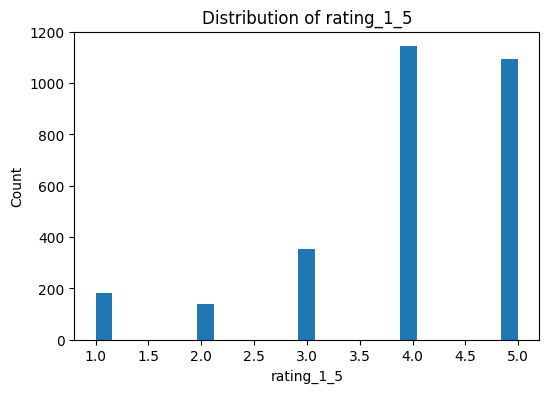

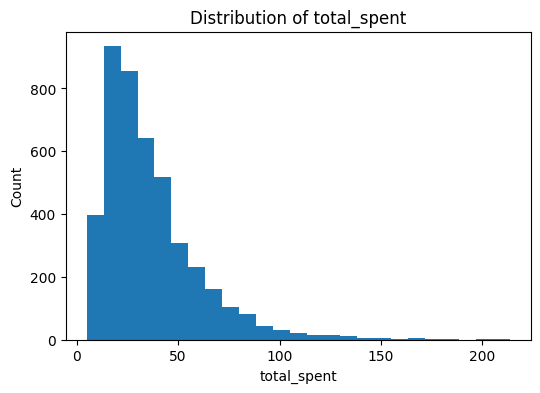

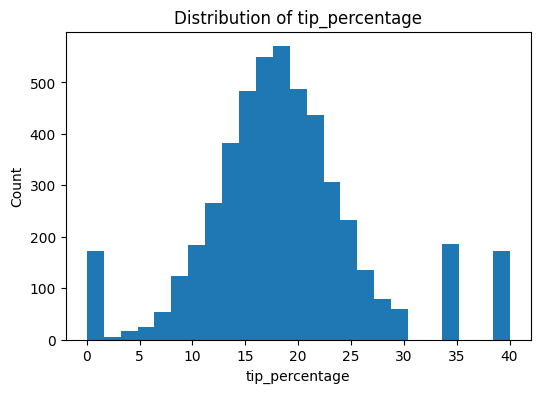

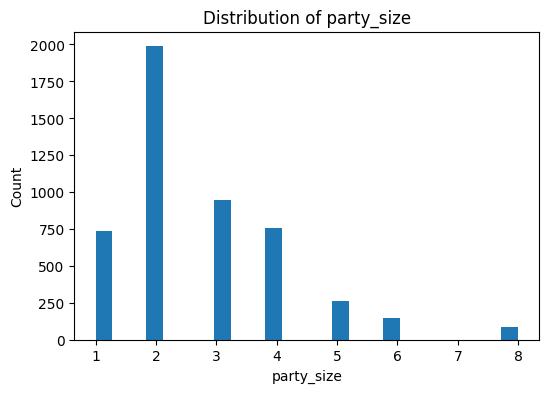

customer_name  _text_norm                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

,total_spent,tip_amount,tip_percentage,source_file
83,171.61,0.00,0.0,tastetrend_downtown_reviews.csv
2508,131.30,13.77,10.5,tastetrend_midtown_reviews.txt
2517,136.09,22.66,16.7,tastetrend_midtown_reviews.txt
2622,130.64,0.00,0.0,tastetrend_midtown_reviews.txt
3290,131.75,46.11,35.0,tastetrend_uptown_reviews.csv


count        3423.0
mean     589.196611
std      515.522159
min            58.0
25%           217.0
50%           436.0
75%           750.0
max          4552.0
Name: review_length, dtype: Float64

[INFO] Rows mentioning waiting: 1,055


In [23]:
# Step 7 — Basic stats & histograms
summary = reviews[["rating_raw","rating_scale","rating_1_5","total_spent","tip_amount","tip_percentage","party_size"]].describe()
display(summary)

scale_by_source = reviews.groupby("source_file")["rating_scale"].agg(["min","max","nunique"])
display(scale_by_source)

def hist(df: pd.DataFrame, col: str, bins: int = 30):
    series = pd.to_numeric(df[col], errors="coerce").dropna()
    if series.empty: return
    plt.figure(figsize=(6,4))
    plt.hist(series, bins=bins)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Count"); plt.show()

for c in ["rating_1_5","total_spent","tip_percentage","party_size"]:
    hist(reviews, c, bins=25)

# Step 8 — Exploratory checks
dupe_keys = ["customer_name", "review_text", "review_date", "restaurant_name"]
maybe_dupes = (
    reviews
    .assign(_text_norm=reviews["review_text"].astype("string").str.lower().str.replace(r"\s+"," ",regex=True))
    .groupby(["customer_name","_text_norm","review_date","restaurant_name"], dropna=False)
    .size().sort_values(ascending=False)
)
display(maybe_dupes.head(10))

outliers_spent = reviews[reviews["total_spent"] > reviews["total_spent"].quantile(0.99)]
display(outliers_spent[["total_spent","tip_amount","tip_percentage","source_file"]].head())

if "review_text" in reviews:
    reviews["review_length"] = reviews["review_text"].astype("string").str.len()
    display(reviews["review_length"].describe())
    KEYWORDS_WAIT = ["wait","waiting","queue","line","delay"]
    rt = reviews["review_text"].astype("string").str.lower()
    reviews["mentions_wait"] = rt.apply(lambda x: any(k in x for k in KEYWORDS_WAIT) if isinstance(x,str) else False)
    logger.info(f"Rows mentioning waiting: {reviews['mentions_wait'].sum():,}")

In [24]:
# Step 9 — Save snapshot
SNAP_PATH = PROJECT_ROOT / "data" / "processed_exploration.parquet"
cols_to_save = [c for c in STANDARD_COLS if c != "rating_scale"] + ["review_length","mentions_wait"]
cols_to_save = [c for c in cols_to_save if c in reviews.columns]
reviews[cols_to_save].to_parquet(SNAP_PATH, index=False)
logger.info(f"Saved exploration snapshot to: {SNAP_PATH}")

[INFO] Saved exploration snapshot to: c:\Users\Bálint\Documents\Pet_projects\tastetrend_analytics_genai\data\processed_exploration.parquet
